# Preprocess

In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import pytz

import gc
import torch

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
class CFG:
    input_dir = os.path.join("/kaggle", "input")
    output_dir = os.path.join("/kaggle", "working")
    competition_dir = os.path.join(input_dir, "child-mind-institute-detect-sleep-states")
    train_series = os.path.join(competition_dir, "train_series.parquet")
    train_event = os.path.join(competition_dir, "train_events.csv")

    test_series = os.path.join(competition_dir, "test_series.parquet")
    sample_sub = os.path.join(competition_dir, "sample_submission.csv")

In [4]:
train_series = pl.read_parquet(CFG.train_series)

In [5]:
train_series = train_series.with_columns(pl.col('timestamp').str.to_datetime().dt.replace_time_zone(None))

In [6]:
train_series = train_series.with_columns(pl.col('timestamp').dt.second().cast(pl.Int32).alias('second'))

In [10]:
train_series = train_series.with_columns(pl.col('timestamp').dt.date().cast(str).alias('date'))

In [11]:
train_series

series_id,step,timestamp,anglez,enmo,second,date
str,u32,datetime[μs],f32,f32,i32,str
"""038441c925bb""",0,2018-08-14 19:30:00,2.6367,0.0217,0,"""2018-08-14"""
"""038441c925bb""",1,2018-08-14 19:30:05,2.6368,0.0215,5,"""2018-08-14"""
"""038441c925bb""",2,2018-08-14 19:30:10,2.637,0.0216,10,"""2018-08-14"""
"""038441c925bb""",3,2018-08-14 19:30:15,2.6368,0.0213,15,"""2018-08-14"""
"""038441c925bb""",4,2018-08-14 19:30:20,2.6368,0.0215,20,"""2018-08-14"""
"""038441c925bb""",5,2018-08-14 19:30:25,2.6367,0.0217,25,"""2018-08-14"""
"""038441c925bb""",6,2018-08-14 19:30:30,2.6367,0.0217,30,"""2018-08-14"""
"""038441c925bb""",7,2018-08-14 19:30:35,2.6367,0.0218,35,"""2018-08-14"""
"""038441c925bb""",8,2018-08-14 19:30:40,2.798,0.0223,40,"""2018-08-14"""


In [ ]:
~~~

In [ ]:
train_series = train_series.to_pandas()

In [ ]:
def preprocess_input(train_series_: pd.DataFrame) -> pd.DataFrame:
    print("get anglez and enmo rolling mean and std")
    roll_num = 12
    train_series_["anglez_mean"] = (
        train_series_.groupby("series_id")["anglez"]
        .rolling(roll_num, center=True)
        .mean()
        .reset_index(0, drop=True)
    )
    train_series_["enmo_mean"] = (
        train_series_.groupby("series_id")["enmo"]
        .rolling(roll_num, center=True)
        .mean()
        .reset_index(0, drop=True)
    )
    train_series_["anglez"] = train_series_["anglez_mean"].fillna(0)
    train_series_["enmo"] = train_series_["enmo_mean"].fillna(0)
    train_series_ = train_series_.drop(columns=["anglez_mean", "enmo_mean"])

    return train_series_

In [ ]:
train_series = preprocess_input(train_series)

get anglez and enmo rolling mean and std


In [ ]:
train_series_zero = train_series[train_series['second'] == 0]

In [ ]:
train_series_zero 

,series_id,step,timestamp,anglez,enmo,second,anglez_mean,enmo_mean
0,038441c925bb,0,2018-08-14 19:30:00,0.000000,0.000000,0,NaN,NaN
12,038441c925bb,12,2018-08-14 19:31:00,2.577875,0.021767,0,2.577875,0.021767
24,038441c925bb,24,2018-08-14 19:32:00,20.189801,0.020133,0,20.189801,0.020133
36,038441c925bb,36,2018-08-14 19:33:00,-79.983509,0.013600,0,-79.983509,0.013600
48,038441c925bb,48,2018-08-14 19:34:00,-80.004567,0.013633,0,-80.004567,0.013633
...,...,...,...,...,...,...,...,...
127946280,fe90110788d2,592320,2017-09-08 04:10:00,15.719683,0.001450,0,15.719683,0.001450
127946292,fe90110788d2,592332,2017-09-08 04:11:00,0.211975,0.021950,0,0.211975,0.021950
127946304,fe90110788d2,592344,2017-09-08 04:12:00,-6.056925,0.013567,0,-6.056925,0.013567
127946316,fe90110788d2,592356,2017-09-08 04:13:00,-32.049742,0.010042,0,-32.049742,0.010042


In [ ]:
df["anglez"].max(), df["anglez"].min(), df["enmo"].max(), df["enmo"].min()

(88.94843292236328, -89.54863039652507, 1.1035500032206376, 0.0)

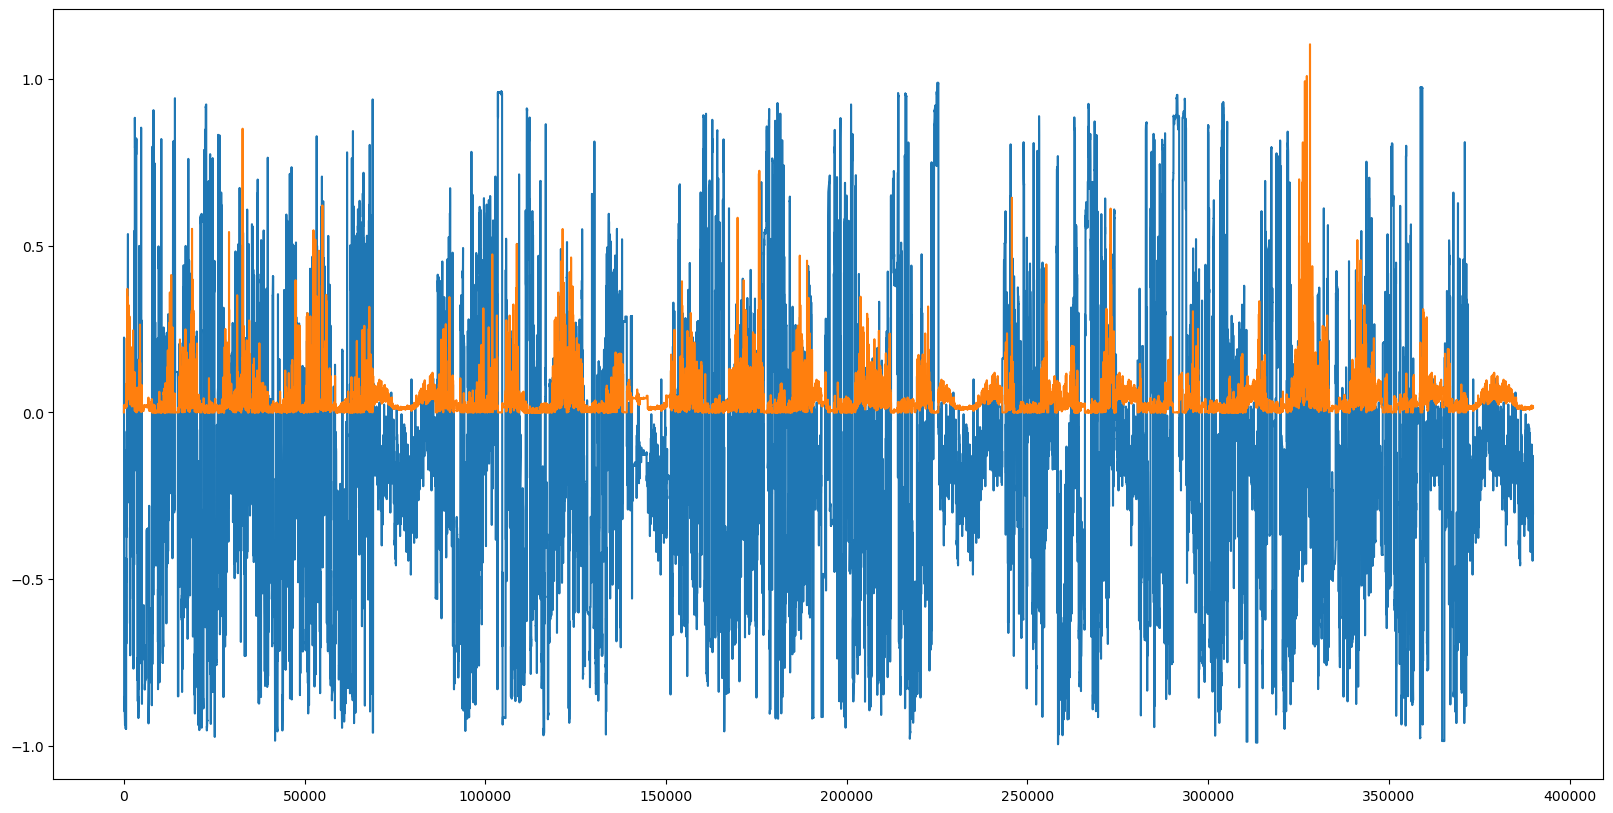

In [ ]:
df = train_series_zero[train_series_zero["series_id"] == "038441c925bb"]
plt.figure(figsize=(20, 10))
plt.plot(df['anglez']/90.0)
plt.plot(df['enmo'])